## 深度神经网络(DNN)
深度神经网络（Deep Neural Networks）是深度学习的基础，接下来我们将会训练一个模型来区分手写数字种类。

### 1. 导入数据
由于是教程，为了大家能够了解模型是怎么使用的，所以数据我们直接采用PyTorch内置的数据，在实践工程当中，大家可以使用Python中的包Pandas导入数据，之后再将数据转化为张量Tensor形式。本次实验，依旧使用MNIST手写数据集。


In [23]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [24]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

* 将数据分割为训练集，验证集

In [25]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
# batch size设置为128
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

* 查看一个batch里的数据

images.shape: torch.Size([128, 1, 28, 28])


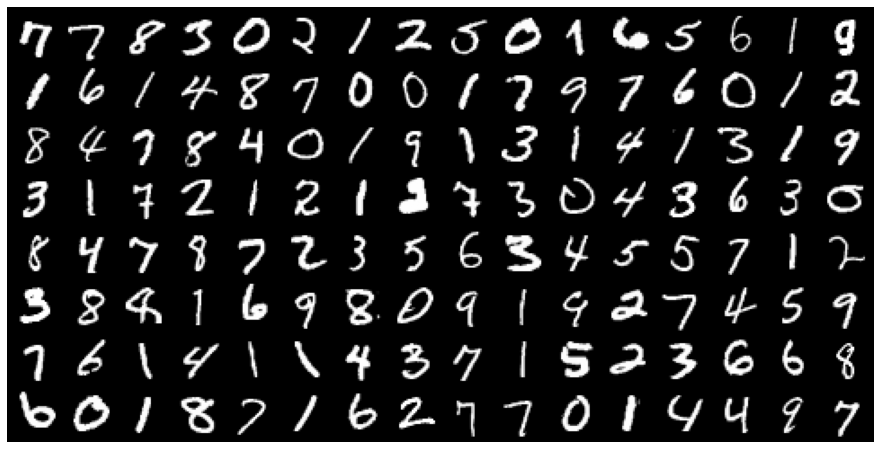

In [26]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break


### 2. 创建模型
我们将创建一个具有两层的神经网络：隐藏层和输出层。


In [27]:
class MnistModel(nn.Module):
    """Feedfoward neural network"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()        
        self.linear1 = nn.Linear(in_size, hidden_size)      
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):

        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                 
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

* accuracy函数用于得到模型的准确率

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
# 模型参数
input_size = 784
hidden_size = 32
num_classes = 10

In [30]:
model = MnistModel(input_size, hidden_size=32, out_size=10)

### 3. 利用GPU训练模型
如果有GPU的话，可以使用GPU加速模型，但是一般情况下CPU也可以满足训练要求。

In [31]:
torch.cuda.is_available() #查看GPU是否配置好

True

In [32]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [33]:
device = get_default_device()
device

device(type='cuda')

下面的代码是将数据传到GPU上，重点在于训练加速，如果数据量不是过大，可以不用下面的步骤。

In [34]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break
class DeviceDataLoader():
    """将数据传到GPU中"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

torch.Size([128, 1, 28, 28])
cuda:0


### 4. 训练模型

我们在下面定义了两个函数：fit()和evaluate()以使用梯度下降算法训练模型和评估性能。

In [35]:
# 查看模型结构
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [36]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
history = fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2502, val_acc: 0.9212
Epoch [1], val_loss: 0.1758, val_acc: 0.9471
Epoch [2], val_loss: 0.1674, val_acc: 0.9506
Epoch [3], val_loss: 0.1466, val_acc: 0.9571
Epoch [4], val_loss: 0.1373, val_acc: 0.9597
Epoch [5], val_loss: 0.1490, val_acc: 0.9576
Epoch [6], val_loss: 0.1404, val_acc: 0.9599
Epoch [7], val_loss: 0.1153, val_acc: 0.9678
Epoch [8], val_loss: 0.1229, val_acc: 0.9643
Epoch [9], val_loss: 0.1242, val_acc: 0.9628


* Loss随epoch的增长而下降图像

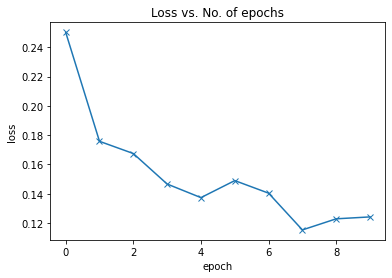

In [38]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

* acc随epoch的增长而上升的图像

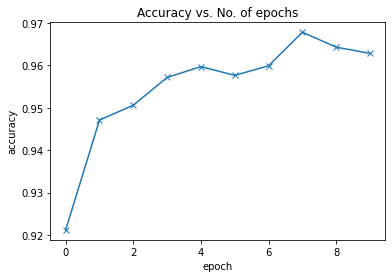

In [39]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

### 4. 测试模型
在测试集上测试模型的准确率

In [40]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [41]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()


* 先选几个样本进行测试，发现预测值和真实值一样

Label: 7 , Predicted: 7


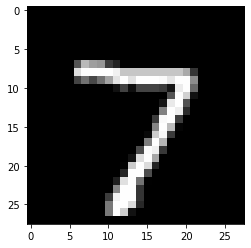

In [42]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


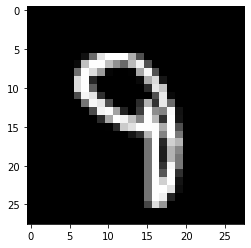

In [43]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

* 查看模型在整个测试集上的准确率
发现比之前逻辑分类的准确率要高很多。

In [44]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.12456903606653214, 'val_acc': 0.962597668170929}

### 5.总结
DNN对于我们来说是认识深度神经网络的基础，PyTorch中的nn模块基本实现了DNN的所有功能，上面举的例子是分类问题。但是对于我们通信领域，上面的功能已经算是过剩了，基本上两个全连接层就能解决大部分问题了。关于DNN算法的具体解释，大家可以参考博客：
https://www.cnblogs.com/pinard/p/6418668.html